# Solving a basic QUBO problem

A QUBO instance on $N$ variables consists in a symmetric matrix $Q$ of size $N\times N$, and solving a QUBO problems means to find the bitstring $z=(z_1,...,z_N)\in\{0, 1\}^N$ that minimizes the quantity

$$
f(z) = z^TQz
$$

## Problem generation

Many real-world problems can be mapped to a QUBO problem, which means to create the matrix $Q$ that encodes the problem to solve. For the purpose of this tutorial we assume this task has already been performed and we are given the matrix $Q$, such as the one below:

In [66]:
import numpy as np

Q = np.array([
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
])

QUBO problems are scale-invariant, and so we can work with the normalized matrix $\tilde{Q}=Q/\text{max}(Q)$ instead.

Before showing how to solve this QUBO instance in the Rydberg analog model, we can compute the optimal solutions classically to compare. For that we do a brute force cost calculation over all possible bitstrings, which scales exponentially with the number of variables. This is only possible because we are dealing with a small QUBO.

In [67]:
# Normalize QUBO matrix
Q = Q/Q.max()

# Classical solution
bitstrings = np.array([np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))])
bitstring_lists = np.array([np.array(list(b), dtype=int) for b in bitstrings])
costs = np.array([z.T @ Q @ z for z in bitstring_lists])
idx_sort = np.argsort(costs).tolist()

sorted_costs = costs[idx_sort]
sorted_bitstrings = bitstrings[idx_sort]

print("Two best solutions: ", sorted_bitstrings[:2])
print("Respective costs: ", sorted_costs[:2])

# We save the two best solutions for plotting
marked_bitstrings = sorted_bitstrings[:2]

Two best solutions:  ['01011' '00111']
Respective costs:  [-1.31978679 -1.31978679]


## Problem embedding

To embed the QUBO problem in the Rydberg analog model, we can directly use a matrix embedding technique like the `InteractionEmbedder`. You can read more about it in the [available embedders contents page](../contents/available_embedders.md#matrix-embedding).

The `InteractionEmbedder` maps a matrix to a graph with node coordinates, from which we can directly instantiate a qubit register later.

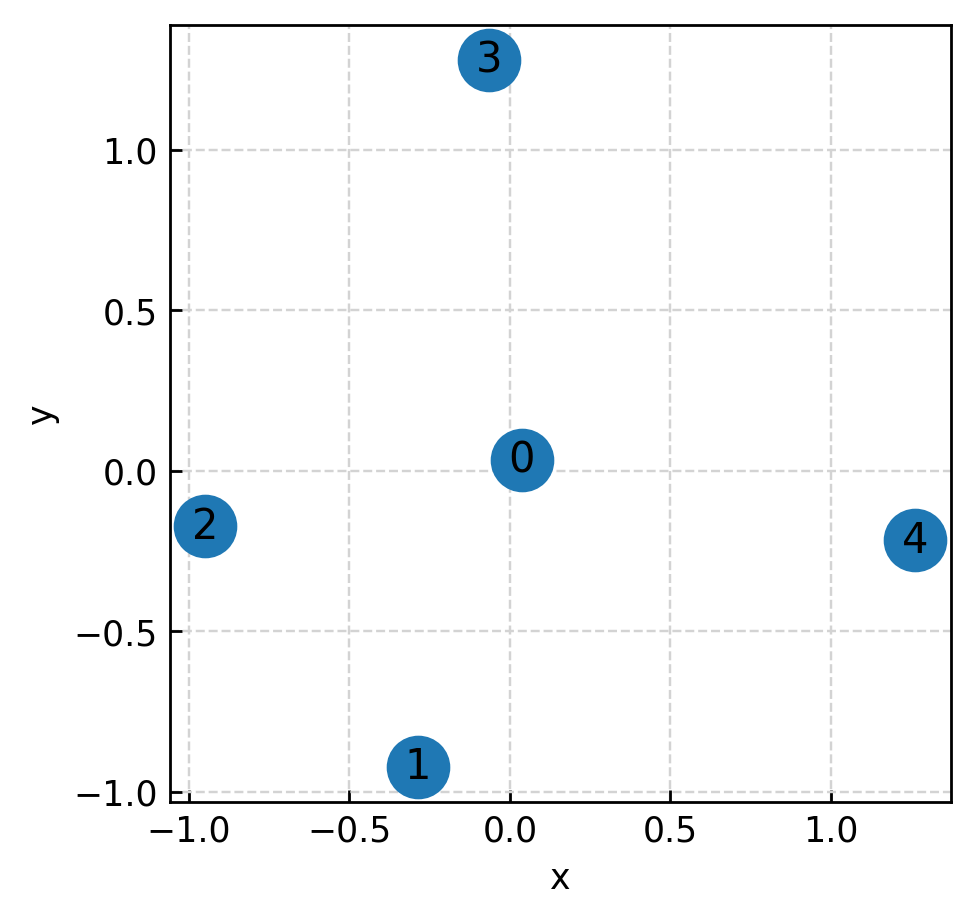

In [68]:
from qoolqit import InteractionEmbedder

embedder = InteractionEmbedder()
embedded_graph = embedder.embed(Q)
embedded_graph.draw()

## Writing a quantum program

To solve this QUBO instance, we are going to use an annealing schedule where we raise the amplitude to some value $\Omega$ while sweeping the detuning from $\delta_i$ to $\delta_f$. We pick the $\Omega$ as the median of the values of $Q$, and define $\delta_i$ and $\delta_f$ as $\pm 2 \Omega$. A long enough duration should allow the annealing schedule to be successful.

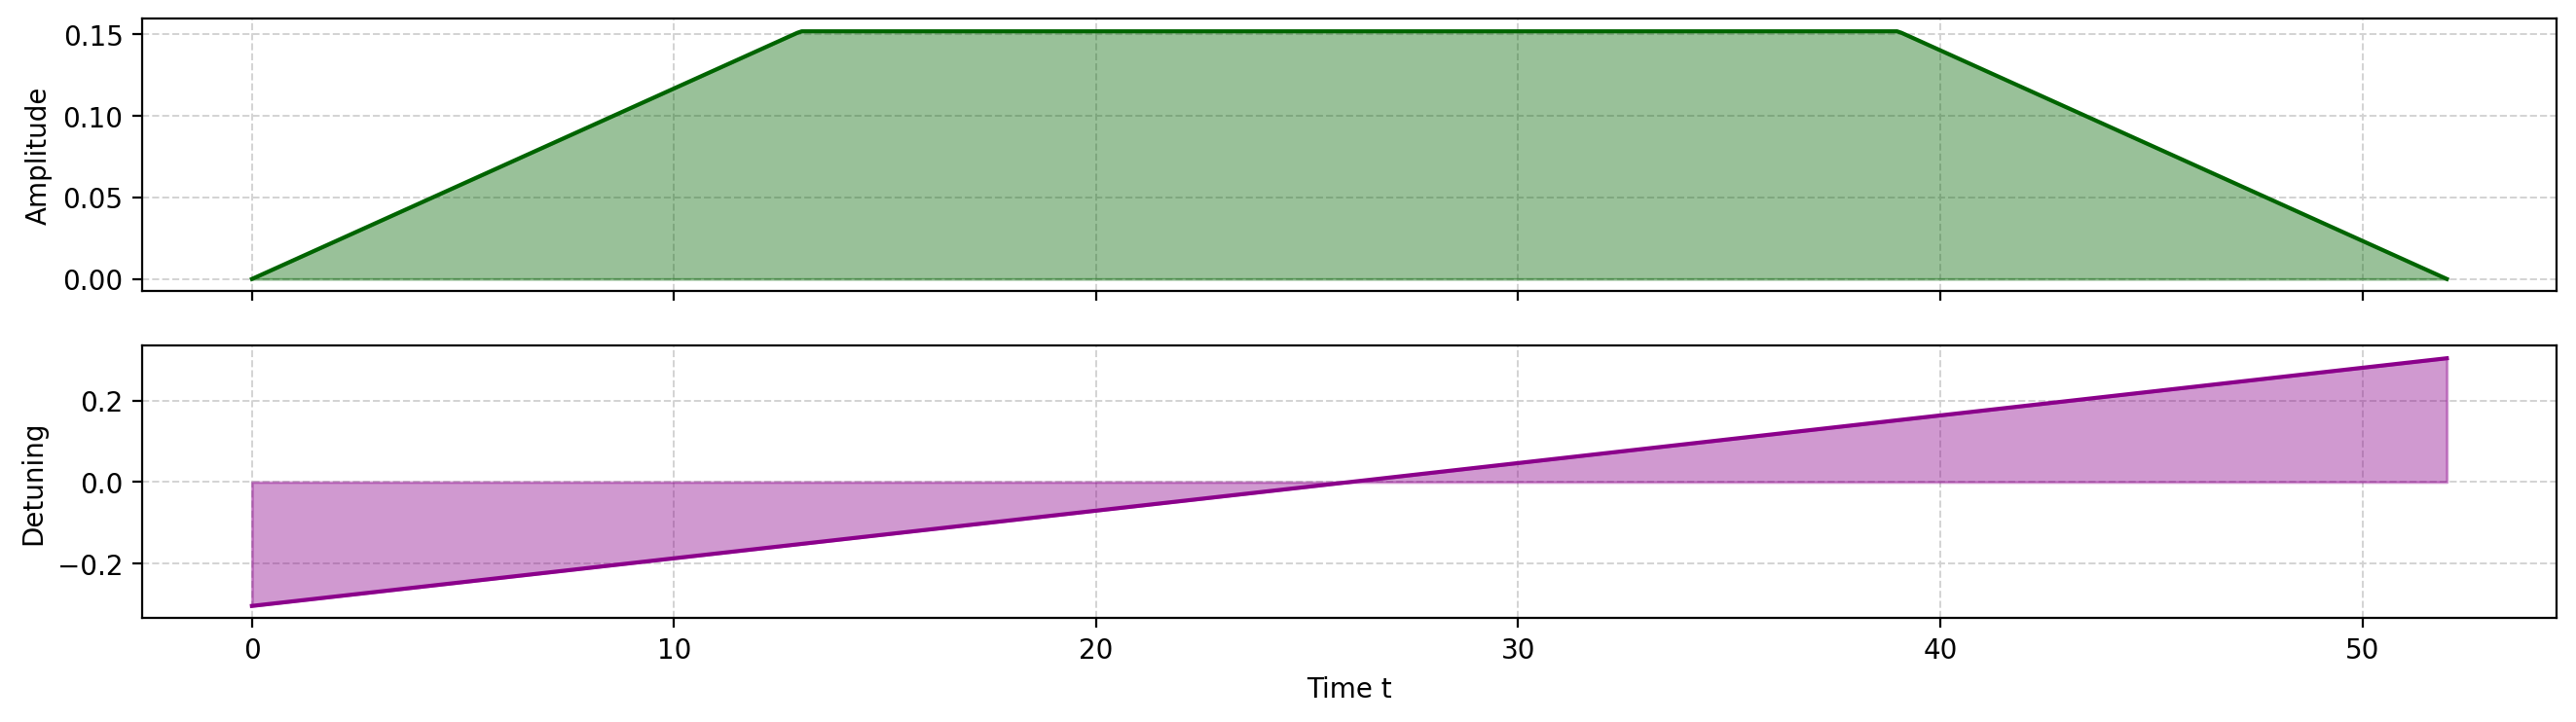

In [69]:
from qoolqit import Drive, PiecewiseLinear, QuantumProgram, Ramp, Register

# Create the register
register = Register.from_graph(embedded_graph)

# Defining the annealing parameters
omega = np.median(Q[Q > 0].flatten())
delta_i = -2.0 * omega
delta_f = 2.0 * omega
T = 52.0

# Defining the annealing schedule
wf_amp = PiecewiseLinear([T/4, T/2, T/4], [0.0, omega, omega, 0.0])
wf_det = Ramp(T, delta_i, delta_f)
drive = Drive(amplitude = wf_amp, detuning = wf_det)

# Writing the quantum program
program = QuantumProgram(register, drive)
program.draw()

## Execution and visualization

We pick the `AnalogDevice`, compile the program, and run it for a set number of samples.

In [70]:
from qoolqit import AnalogDevice

program.compile_to(device = AnalogDevice())

The program can now be executed. 

In [71]:
from qoolqit.execution import LocalEmulator

emulator = LocalEmulator(runs=500)

results = emulator.run(program)

counter = results[0].final_bitstrings
print(counter)

Counter({np.str_('01011'): 223, np.str_('00111'): 191, np.str_('00011'): 35, np.str_('10000'): 15, np.str_('10001'): 10, np.str_('00101'): 8, np.str_('00010'): 6, np.str_('10010'): 5, np.str_('01010'): 5, np.str_('00001'): 2})


And finally we plot a histogram of the sampled bitstrings.

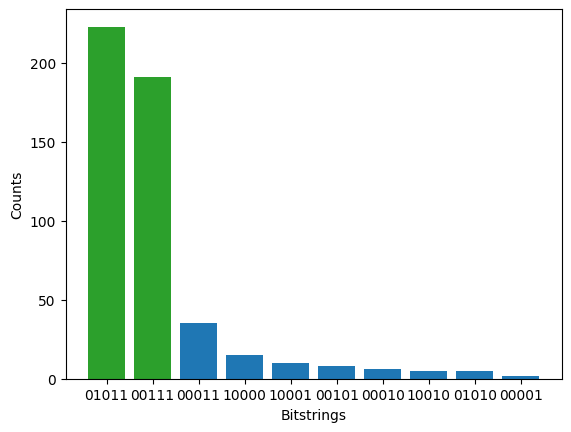

In [72]:
import matplotlib.pyplot as plt


def plot_distribution(counter, solutions, bins=10):
    counter = dict(counter.most_common(bins))
    color = ["tab:green" if key in solutions.tolist() else "tab:blue" for key in counter]
    fig, ax = plt.subplots()
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.bar(range(len(counter)), counter.values(), color=color, tick_label=counter.keys())
    return fig

fig = plot_distribution(counter, marked_bitstrings)

As we can see, the bitstrings we had marked as the optimal solutions of this QUBO problem were the ones sampled with the highest probability, meaning the the QUBO problem was successfully solved with the quantum program we defined.